# Geolocalización

En esta notebook haremos un intento de geolocalización con los textos de los usuarios... pero usando la medida IGR de Han, Cook y compañía


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_json("data/geoloc/users_train.json")
df_test = pd.read_json("data/geoloc/users_test.json")

Hagamos lo siguiente:

- Entrenemos con unigramas una regresión logística para 
- Luego probemos con los regionalismos

Primero, partamos en train, test

In [2]:
%%time
from contrastes.processing import build_dataframe_from_users

word_df = build_dataframe_from_users(row for index, row in df_train.iterrows())

CPU times: user 7min 13s, sys: 392 ms, total: 7min 14s
Wall time: 7min 14s


In [3]:
from contrastes.processing import preprocess_raw_df

word_df = preprocess_raw_df(word_df, filter_words=(10, 2))

/home/jmperez/projects/contrastes/notebooks/contrastes/processing.py:185: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columnas_palabras = cant_palabras
/home/jmperez/projects/contrastes/notebooks/contrastes/processing.py:186: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columnas_personas = cant_personas


In [4]:
from scipy.stats import entropy

data = word_df[word_df.columnas_palabras]
total_words = data.sum()

In [5]:
h_c = entropy(total_words)
h_c

3.123336105874412

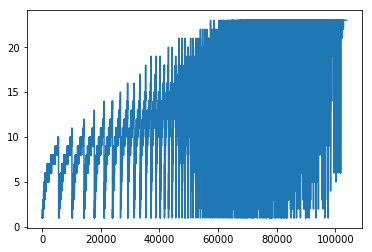

In [49]:
import matplotlib.pyplot as plt

plt.plot(range(len(word_df)), word_df["cant_provincias"])




In [63]:
import numpy as np

p_wi = word_df.cant_palabra / word_df.cant_palabra.sum()
p_notwi = 1 -p_wi

cond_entr_wi = data.apply(entropy, axis=1, raw=True)
cond_entr_not_wi = (total_words - data).apply(entropy, axis=1, raw=True)

word_df["ig"] = h_c - (p_wi * cond_entr_wi + p_notwi * cond_entr_not_wi)
word_df["iv"] = -p_wi * np.log(p_wi) - p_notwi * np.log(p_notwi)

word_df["igr"] = word_df["ig"] / word_df["iv"]

In [65]:
word_df.sort_values("igr", ascending=False, inplace=True)

word_df[:30][word_df.columnas_palabras]

,buenosaires_ocurrencias,catamarca_ocurrencias,chaco_ocurrencias,chubut_ocurrencias,cordoba_ocurrencias,corrientes_ocurrencias,entrerios_ocurrencias,formosa_ocurrencias,jujuy_ocurrencias,lapampa_ocurrencias,...,neuquen_ocurrencias,rionegro_ocurrencias,salta_ocurrencias,sanjuan_ocurrencias,sanluis_ocurrencias,santacruz_ocurrencias,santafe_ocurrencias,santiago_ocurrencias,tierradelfuego_ocurrencias,tucuman_ocurrencias
rioja,21.0,219.0,3.0,18.0,23.0,21.0,6.0,2.0,27.0,9.0,...,4.0,7.0,57.0,88.0,3.0,10.0,45.0,11.0,4.0,44.0
logroño,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hoa,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3275.0,...,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
ushuaia,19.0,2.0,3.0,16.0,3.0,2.0,3.0,4.0,6.0,7.0,...,7.0,13.0,72.0,8.0,4.0,35.0,6.0,14.0,5640.0,2.0
chepes,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
tiemposur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,883.0,0.0,0.0,0.0,0.0
palpala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,591.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
beder,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
quitilipi,0.0,0.0,1043.0,0.0,0.0,10.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oberá,0.0,1.0,1.0,3.0,0.0,2.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0


Veamos qué performance tiene usando 1000, 2000, 3000, y así...

In [66]:
from sklearn.preprocessing import LabelEncoder

province_encoder = LabelEncoder()

province_encoder.fit(df_train["provincia"].values)
y_train = province_encoder.transform(df_train["provincia"].values)
y_test = province_encoder.transform(df_test["provincia"].values)

In [67]:
%%time 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
liw_vectorizer = CountVectorizer(
    tokenizer=tokenizer.tokenize,
    vocabulary=word_df.index)

X_train = liw_vectorizer.fit_transform(df_train["text"])
print("Vectorizing")
X_test = liw_vectorizer.transform(df_test["text"])

Vectorizing
CPU times: user 9min 7s, sys: 276 ms, total: 9min 7s
Wall time: 9min 7s


Ya las tenemos vectorizadas en el orden esperado!

In [68]:
from sklearn.linear_model import LogisticRegression

clfs = {}
scores = {}

In [71]:


for num_words in range(250, 5000, 250):    
    if num_words in clfs:
        print("{} palabras ----> accuracy {:.2f}".format(num_words, scores[num_words]*100))
        continue
    X_tr = X_train[:, :num_words].todense()
    X_tst = X_test[:, :num_words].todense()
    
    clf = LogisticRegression(
        multi_class='multinomial', solver='saga', penalty='l2', 
        max_iter=200, n_jobs=-1)
    clf.fit(X_tr, y_train)
    
    scores[num_words] = clf.score(X_tst, y_test)
    print("{} palabras ----> accuracy {:.2f}".format(num_words, scores[num_words]*100))
    clfs[num_words] = clf
    

250 palabras ----> accuracy 41.96
500 palabras ----> accuracy 51.12
750 palabras ----> accuracy 56.28
1000 palabras ----> accuracy 58.32
1250 palabras ----> accuracy 59.72
1500 palabras ----> accuracy 61.68
1750 palabras ----> accuracy 62.36
2000 palabras ----> accuracy 63.04
2250 palabras ----> accuracy 62.88
2500 palabras ----> accuracy 64.56
2750 palabras ----> accuracy 65.20
3000 palabras ----> accuracy 65.44
3250 palabras ----> accuracy 65.80
3500 palabras ----> accuracy 66.24
3750 palabras ----> accuracy 67.00
4000 palabras ----> accuracy 67.80
4250 palabras ----> accuracy 69.04
4500 palabras ----> accuracy 68.96
4750 palabras ----> accuracy 69.12


2500 palabras dan un accuracy de 71%. BASTANTE BIEN. Luego disminuye la performance

In [ ]:
for num_words in range(5000, 20000, 500):
    if num_words in clfs:
        print("{} palabras ----> accuracy {:.2f}".format(num_words, scores[num_words]*100))
        continue
    
    X_tr = X_train[:, :num_words].todense()
    X_tst = X_test[:, :num_words].todense()
    
    clf = LogisticRegression(
        multi_class='multinomial', solver='saga', penalty='l2', 
        max_iter=200, n_jobs=-1)
    clf.fit(X_tr, y_train)
    
    scores[num_words] = clf.score(X_tst, y_test)
    print("{} palabras ----> accuracy {:.2f}".format(num_words, scores[num_words]*100))
    clfs[num_words] = clf

5000 palabras ----> accuracy 69.32
5500 palabras ----> accuracy 66.24
6000 palabras ----> accuracy 66.72
6500 palabras ----> accuracy 67.20
7000 palabras ----> accuracy 66.36
7500 palabras ----> accuracy 65.04
8000 palabras ----> accuracy 65.84
8500 palabras ----> accuracy 65.56
9000 palabras ----> accuracy 66.52
9500 palabras ----> accuracy 66.64
10000 palabras ----> accuracy 66.72
10500 palabras ----> accuracy 66.92
11000 palabras ----> accuracy 66.60
11500 palabras ----> accuracy 66.44
12000 palabras ----> accuracy 66.64


In [73]:

scores

{250: 0.4196,
 500: 0.5112,
 750: 0.5628,
 1000: 0.5832,
 1250: 0.5972,
 1500: 0.6168,
 1750: 0.6236,
 2000: 0.6304,
 2250: 0.6288,
 2500: 0.6456,
 2750: 0.652,
 3000: 0.6544,
 3250: 0.658,
 3500: 0.6624,
 3750: 0.67,
 4000: 0.678,
 4250: 0.6904,
 4500: 0.6896,
 4750: 0.6912,
 5000: 0.6932,
 5500: 0.6624,
 6000: 0.6672,
 6500: 0.672,
 7000: 0.6636,
 7500: 0.6504,
 8000: 0.6584,
 8500: 0.6556,
 9000: 0.6652,
 9500: 0.6664,
 10000: 0.6672,
 10500: 0.6692,
 11000: 0.666,
 11500: 0.6644,
 12000: 0.6664,
 12500: 0.666,
 13000: 0.6732,
 13500: 0.674,
 14000: 0.6828,
 14500: 0.6836,
 15000: 0.6848,
 15500: 0.6856,
 16000: 0.6848,
 16500: 0.6864,
 17000: 0.688,
 17500: 0.6804,
 18000: 0.68,
 18500: 0.678,
 19000: 0.6792,
 19500: 0.6804}

In [74]:
import pickle

pickle.dump(clfs, open("clfs_igr_palabras.pkl", "wb"))
